# Models without latent features

It can be observed that the previous models have achieved relatively good results. The regression models are able to get a R2 score of above 0.65, MAE of around 12.3 and MSE ranging from 700 to 900. With other techniques like PCA applied, the performance of the models can be further improved. Classification models are generally returning a high accuracy of over 90% (apart from SVM and kNN) in their default parameters. 

However the predictions carried out in the initial phase might not be the most useful because we have included many features that are available only after the sets are released. These features do not help collectors/investors to determine a set's value early on. Therfore to mitigate this problem, we will exclude the latent variables and perform the predictions solely by the other features which do not include much human influence (e.g. number of piece, themes).

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost/capstone')
lego = pd.read_sql('SELECT * FROM lego_cleaned_temp', engine)
lego.head()

,Item_Number,Name,Year,Theme,Subtheme,Pieces,Minifigures,Image_URL,USD_MSRP,Packaging,Availability,wanted,owned,rating,theme_grp,review_num,query_id,adjust_coef,adj_USD_MSRP
0,10246,Detective's Office,2015,Advanced Models,Modular Buildings,2262.0,6.0,http://images.brickset.com/sets/images/10246-1...,159.99,Box,Retail - limited,5008.0,10155.0,4.75,Model making,4,10246-1,1.0,159.99
1,10247,Ferris Wheel,2015,Advanced Models,Fairground,2464.0,10.0,http://images.brickset.com/sets/images/10247-1...,199.99,Box,Retail - limited,3219.0,4807.0,5,Model making,3,10247-1,1.0,199.99
2,10248,Ferrari F40,2015,Advanced Models,Vehicles,1158.0,0.0,http://images.brickset.com/sets/images/10248-1...,99.99,Box,LEGO exclusive,2030.0,3943.0,5,Model making,4,10248-1,1.0,99.99
3,10249,Toy Shop,2015,Advanced Models,Winter Village,898.0,0.0,http://images.brickset.com/sets/images/10249-1...,79.99,Box,LEGO exclusive,2046.0,4794.0,4,Model making,1,10249-1,1.0,79.99
4,10581,Ducks,2015,Duplo,Forest Animals,13.0,1.0,http://images.brickset.com/sets/images/10581-1...,9.99,Box,Retail,117.0,444.0,0,Pre-school,0,10581-1,1.0,9.99


In [3]:
lego['labels'] = lego.wanted.apply(lambda x:0 if x<1091 else 1)

# Dropping all the columns with unique features which do not add information to the models
lego = lego.drop(['Item_Number','Name','Image_URL','USD_MSRP','query_id','adjust_coef'], axis=1)

# Get dummies for categorical variables
theme = pd.get_dummies(lego.Theme, drop_first=True)
subtheme = pd.get_dummies(lego.Subtheme, drop_first=True)
packaging = pd.get_dummies(lego.Packaging, drop_first=True)
availability = pd.get_dummies(lego.Availability, drop_first=True)
theme_grp = pd.get_dummies(lego.theme_grp, drop_first=True)

# Drop the original categorical columns
lego = lego.drop(['Theme','Subtheme','Packaging','Availability','theme_grp'],axis=1)

# drop latent features
lego = lego.drop(['wanted','owned','review_num','rating'],axis=1) 


In [4]:
lego_w_dummies = pd.concat([lego,theme,subtheme,packaging,availability,theme_grp],axis=1)
no_lego = pd.concat([theme,subtheme,packaging,availability,theme_grp],axis=1)
lego_w_dummies.head(2)

,Year,Pieces,Minifigures,adj_USD_MSRP,labels,Action Wheelers,Advanced Models,Adventurers,Agents,Alpha Team,...,Historical,Junior,Licensed,Miscellaneous,Model making,Modern day,Pre-school,Racing,Technical,Vintage themes
0,2015,2262.0,6.0,159.99,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2015,2464.0,10.0,199.99,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Regression

In [8]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
X = lego_w_dummies.drop(['adj_USD_MSRP','labels'], axis=1)
y = lego_w_dummies['adj_USD_MSRP']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
ridge_model = Ridge().fit(X_train,y_train)
ridge_pred = ridge_model.predict(X_test)
r2score = cross_val_score(Ridge(),X,y,cv=10)
maescore = cross_val_score(Ridge(),X,y,cv=10,scoring='neg_mean_absolute_error')
msescore = cross_val_score(Ridge(),X,y,cv=10,scoring='neg_mean_squared_error')
print 'MSE: ',mean_squared_error(y_test,ridge_pred)
print 'MAE: ',mean_absolute_error(y_test,ridge_pred)
print 'R2: ', r2_score(y_test,ridge_pred)
print '10 fold CV average R2: ', np.mean(r2score)
print '10 fold CV R2 standard deviation: ', np.std(r2score)
print '10 fold CV average MAE: ', np.mean(maescore)
print '10 fold CV MAE standard deviation: ', np.std(maescore)
print '10 fold CV average MSE: ', np.mean(msescore)
print '10 fold CV MSE standard deviation: ', np.std(msescore)


MSE:  763.811067382
MAE:  12.7532007165
R2:  0.667182658993
10 fold CV average R2:  0.668513545505
10 fold CV R2 standard deviation:  0.108403555081
10 fold CV average MAE:  -14.1765209034
10 fold CV MAE standard deviation:  3.73457108627
10 fold CV average MSE:  -702.108491892
10 fold CV MSE standard deviation:  311.603950843


In [9]:
lasso_model = Lasso().fit(X_train,y_train)
lasso_pred = lasso_model.predict(X_test)
score = cross_val_score(Lasso(),X,y,cv=10)
maescore = cross_val_score(Lasso(),X,y,cv=10,scoring='neg_mean_absolute_error')
msescore = cross_val_score(Lasso(),X,y,cv=10,scoring='neg_mean_squared_error')
print 'MSE: ',mean_squared_error(y_test,lasso_pred)
print 'MAE: ',mean_absolute_error(y_test,lasso_pred)
print 'R2: ', r2_score(y_test,lasso_pred)
print '10 fold CV average R2: ', np.mean(score)
print '10 fold CV R2 standard deviation: ', np.std(score)
print '10 fold CV average MAE: ', np.mean(maescore)
print '10 fold CV MAE standard deviation: ', np.std(maescore)
print '10 fold CV average MSE: ', np.mean(msescore)
print '10 fold CV MSE standard deviation: ', np.std(msescore)
score

MSE:  824.613692919
MAE:  14.6101617005
R2:  0.640688976168
10 fold CV average R2:  0.627388642531
10 fold CV R2 standard deviation:  0.135254182428
10 fold CV average MAE:  -14.7263056322
10 fold CV MAE standard deviation:  4.81294466103
10 fold CV average MSE:  -789.919480803
10 fold CV MSE standard deviation:  373.036440241


array([ 0.85047748,  0.68833183,  0.76797285,  0.74898744,  0.65034133,
        0.45152324,  0.60075366,  0.6129123 ,  0.46726733,  0.43531896])

Both the cross validation scores and test set results demonstrate that by removing the latent features, the performance of the regression models have fallen slightly. However it should be noted that the CV standard deviation has more than doubled which indicates that the stability of model has suffered significantly. It will be interesting to see what would happen if the models are further tuned.

In [20]:
from sklearn.model_selection import GridSearchCV
params = {'alpha':np.logspace(-3,3,7)}
clf = Lasso(max_iter=3000)
gscv = GridSearchCV(clf,params,cv=10)
model = gscv.fit(X_train,y_train)
print model.best_score_
print model.best_params_
for s in model.cv_results_:
    print s

0.704278190114
{'alpha': 0.01}
rank_test_score
split6_test_score
split7_train_score
split0_train_score
split2_test_score
mean_fit_time
split3_train_score
split6_train_score
split9_test_score
std_test_score
params
split8_test_score
std_score_time
std_fit_time
std_train_score
split4_test_score
split1_train_score
split2_train_score
split4_train_score
mean_score_time
split9_train_score
split5_test_score
mean_train_score
split8_train_score
split7_test_score
split0_test_score
mean_test_score
split3_test_score
split5_train_score
param_alpha
split1_test_score


In [23]:
model.cv_results_['params']

({'alpha': 0.001},
 {'alpha': 0.01},
 {'alpha': 0.10000000000000001},
 {'alpha': 1.0},
 {'alpha': 10.0},
 {'alpha': 100.0},
 {'alpha': 1000.0})

In [ ]:
params = {'alpha':np.logspace(-3,3,7)}
clf = Ridge(max_iter=3000)
gscv = GridSearchCV(clf,params,cv=10)
model = gscv.fit(X_train,y_train)
print model.best_score_
print model.best_params_
for s in model.cv_results_:
    print s

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, classification_report, confusion_matrix, precision_score, recall_score, f1_score
X = no_lego
y = lego_w_dummies['labels']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
clf = LogisticRegression(penalty='l1', C=10)
model = clf.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.919768403639
ROCAUC:  0.862071460466
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       956
          1       0.84      0.76      0.80       253

avg / total       0.92      0.92      0.92      1209

[[919  37]
 [ 60 193]]


In [30]:
coeflst = zip(list(no_lego.columns), model.coef_[0])
xxx = sorted(coeflst, key = lambda x: x[1], reverse = True)
xxx[:5]

[(u'Model making', 9.27886341681746),
 (u'Collectable Minifigures', 7.8042826476730216),
 (u'Ideas', 7.5289092680796514),
 (u'Monorail', 7.2031355249264291),
 (u'Licensed', 7.0449627352655506)]

In [31]:
xxx[-5:]

[(u"Knights' Kingdom II", -6.492913961750955),
 (u'Galidor', -6.4933543320485958),
 (u'Cars', -6.6586049128179621),
 (u'Constraction', -7.7626963270525087),
 (u'Product Collection', -8.5134974869251732)]

In [24]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=5).fit(X_train, y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.928866832093
ROCAUC:  0.873637686672
             precision    recall  f1-score   support

          0       0.94      0.97      0.96       956
          1       0.87      0.78      0.82       253

avg / total       0.93      0.93      0.93      1209

[[926  30]
 [ 56 197]]


,Year,Pieces,Minifigures,adj_USD_MSRP,labels,Action Wheelers,Advanced Models,Adventurers,Agents,Alpha Team,...,Historical,Junior,Licensed,Miscellaneous,Model making,Modern day,Pre-school,Racing,Technical,Vintage themes
0,2015,2262.0,6.0,159.99,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2015,2464.0,10.0,199.99,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2015,1158.0,0.0,99.99,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2015,898.0,0.0,79.99,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2015,13.0,1.0,9.99,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


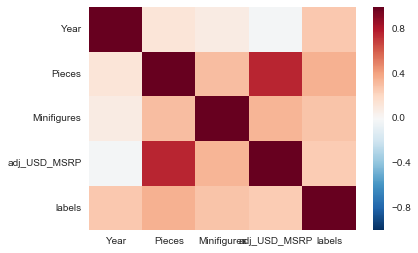

In [19]:
sns.heatmap(lego.corr())
plt.show()

In [32]:
no_lego.head()

,Action Wheelers,Advanced Models,Adventurers,Agents,Alpha Team,Aqua Raiders,Aquazone,Architecture,Assorted,Atlantis,...,Historical,Junior,Licensed,Miscellaneous,Model making,Modern day,Pre-school,Racing,Technical,Vintage themes
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
